In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cpu


In [4]:
train_dataset = torchvision.datasets.FashionMNIST("./data", download = True,
                                                 transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("./data", download = True, 
                                                train = False, transform = transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

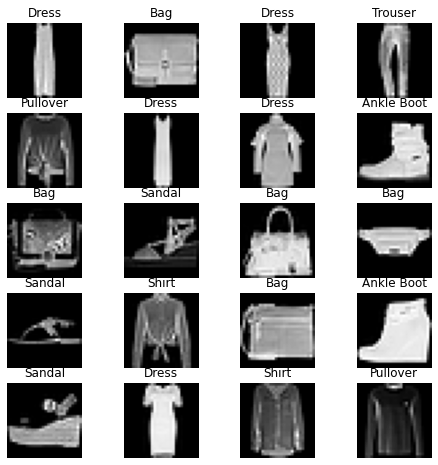

In [6]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize = (8, 8))
columns = 4
rows = 5

for i in range (1, columns * rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')
plt.show()

In [7]:
print(train_dataset[0][0].size())

torch.Size([1, 28, 28])


In [8]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features = 784, out_features = 256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 10)
        
    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
        

In [9]:
learning_rate =  0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)


FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28)) # 자동 미분을 수행해주는 Autograd 패키지가 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산해 준다.
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # 기울기 초기화. <- 없으면 loss.backward()에서 새로운 기울기 값이 이전 기울기 값에 누적하여 계산된다.
        loss.backward()
        optimizer.step() # 전달받은 파라미터들을 업데이트
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28)) 
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device) # 가장 큰 확률이 몇번 label에 속하는지에 대한 index 받아오기
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))




Iteration: 500, Loss: 0.5808276534080505, Accuracy: 83.44000244140625%
Iteration: 1000, Loss: 0.43328192830085754, Accuracy: 84.69000244140625%
Iteration: 1500, Loss: 0.33994144201278687, Accuracy: 84.7699966430664%
Iteration: 2000, Loss: 0.3718816339969635, Accuracy: 85.63999938964844%
Iteration: 2500, Loss: 0.2934856116771698, Accuracy: 85.56999969482422%
Iteration: 3000, Loss: 0.27916219830513, Accuracy: 86.68000030517578%


In [11]:
p = torch.randn([2, 3])
print(p)
max_element = torch.max(p)
print(max_element)
max_elem = torch.max(p, 1)
print(max_elem)
print(max_elem[0])

tensor([[-0.6819,  2.2888, -0.6446],
        [ 0.2202,  1.7228,  1.4682]])
tensor(2.2888)
torch.return_types.max(
values=tensor([2.2888, 1.7228]),
indices=tensor([1, 1]))
tensor([2.2888, 1.7228])


In [29]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features = 64 * 6 * 6, out_features = 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features = 600, out_features = 120)
        self.fc3 = nn.Linear(in_features = 120, out_features = 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out 

In [30]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [31]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28)) # 자동 미분을 수행해주는 Autograd 패키지가 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산해 준다.
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # 기울기 초기화. <- 없으면 loss.backward()에서 새로운 기울기 값이 이전 기울기 값에 누적하여 계산된다.
        loss.backward()
        optimizer.step() # 전달받은 파라미터들을 업데이트
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28)) 
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device) # 가장 큰 확률이 몇번 label에 속하는지에 대한 index 받아오기
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))




Iteration: 500, Loss: 0.5207067131996155, Accuracy: 86.62000274658203%
Iteration: 1000, Loss: 0.30120840668678284, Accuracy: 88.45999908447266%
Iteration: 1500, Loss: 0.31387630105018616, Accuracy: 87.95999908447266%
Iteration: 2000, Loss: 0.24651211500167847, Accuracy: 89.44000244140625%
Iteration: 2500, Loss: 0.1656363308429718, Accuracy: 89.97000122070312%
Iteration: 3000, Loss: 0.16105660796165466, Accuracy: 89.97000122070312%
